In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
from sklearn.utils import resample
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#load dataset
df = pd.read_csv("financial_sentiment.csv")
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


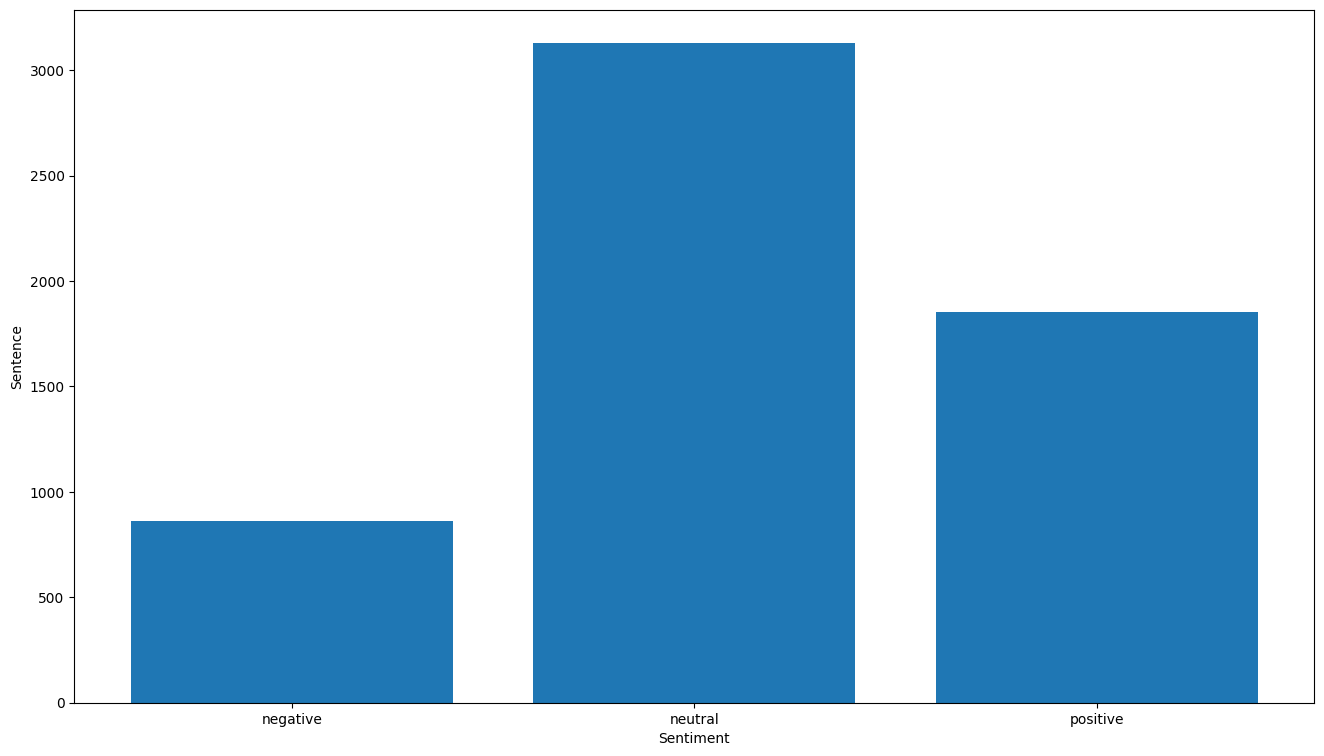

In [3]:
#count sentences from each sentiment
count_sentence = df.groupby('Sentiment')['Sentence'].count()
#Apa aja indeks levelnya
count_sentence.index
#Berapa jumlah data sesuai dengan indeks levelnya
count_sentence.values

plt.figure(figsize=(16, 9))
plt.bar(count_sentence.index, count_sentence.values)
plt.xlabel('Sentiment')
plt.ylabel('Sentence')
plt.show()

In [4]:
#resample 3000
#diduplikasi data negative dan positive sama dengan jumlah data netral yaitu 3000
#dataset yang jumlahnya tidak merata lakukan resample
grouped_sentiment = df.groupby('Sentiment')
resample_list = []

for sentiment, group in grouped_sentiment:
    resampled = resample(group, 
                         replace=True, 
                         n_samples=3000, 
                         random_state=0)
    resample_list.append(resampled)
    
df = pd.concat(resample_list)

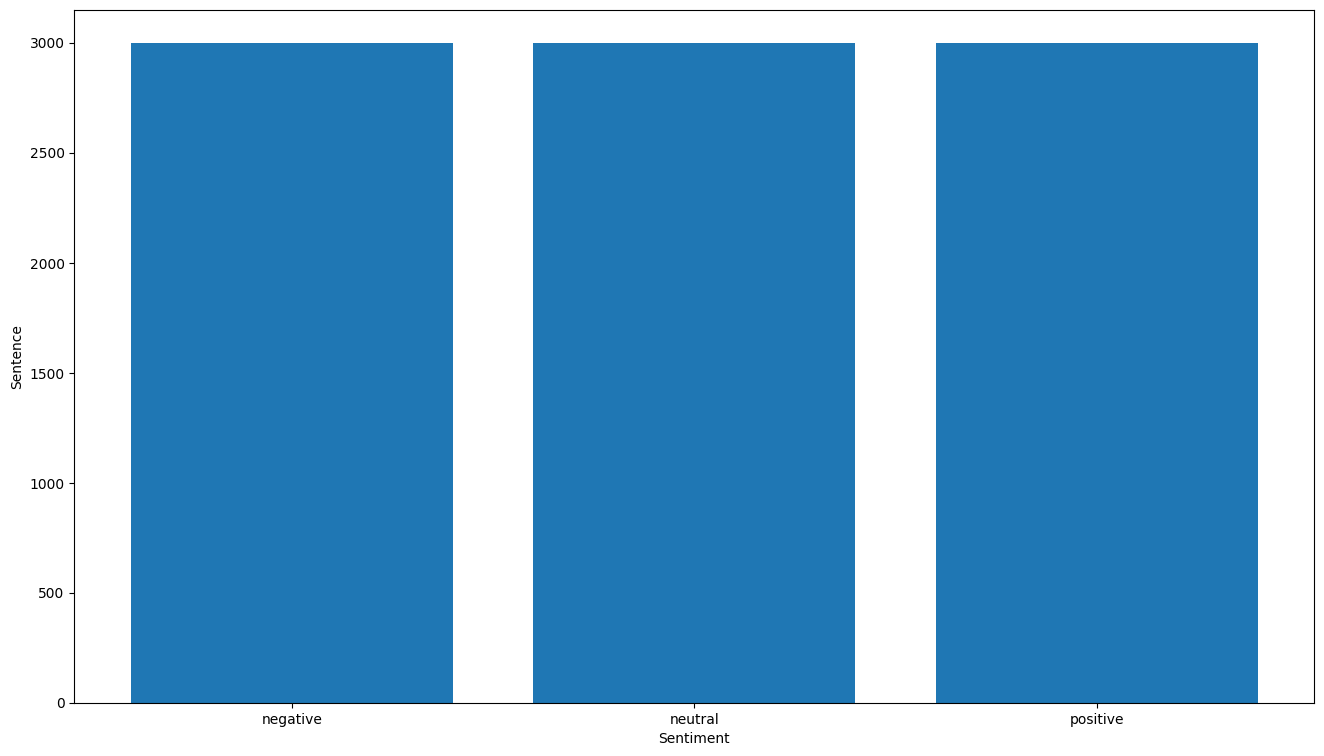

In [5]:
#count sentences from each sentiment
count_sentence = df.groupby('Sentiment')['Sentence'].count()
plt.figure(figsize=(16, 9))
plt.bar(count_sentence.index, count_sentence.values)
plt.xlabel('Sentiment')
plt.ylabel('Sentence')
plt.show()

In [6]:
#remove special characters, lower case, remove stop words
nltk.download('stopwords')

def remove_special_characters(text):
    new_string = ''
    for character in text:
        if character.isalnum() or character.isspace():
            new_string += character
    return new_string
    
def lower(text):
    return text.lower()

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_word = [word for word in words if word not in stop_words]
    return ' '.join(filtered_word)

#Apply functionnya ke dataset
df['Sentence'] = df['Sentence'].apply(remove_special_characters)
df['Sentence'] = df['Sentence'].apply(lower)
df['Sentence'] = df['Sentence'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wsusa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [7]:
#label encoder (Sentiment)

#Sentimentnya ada Negative, Neutral, Positive
#diencode jadi 0, 1, 2
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

df

,Sentence,Sentiment
4750,spy less 02 people calling bearish heading exi...,0
3854,1201 pm omx helsinki 25 066 pct 314357 omx hel...,0
4330,operating margin came 24 57,0
1369,rapala vmc corporation stock exchange release ...,0
5726,arm slammed handset sales outlook,0
...,...,...
1868,finnish government announced wednesday sold 32...,2
3501,addition fireplace exports demand lining stone...,2
510,nyrstar also agreed supply talvivaara 150000 t...,2
3756,crh adds cr laurence acquisitions tally 13bn,2


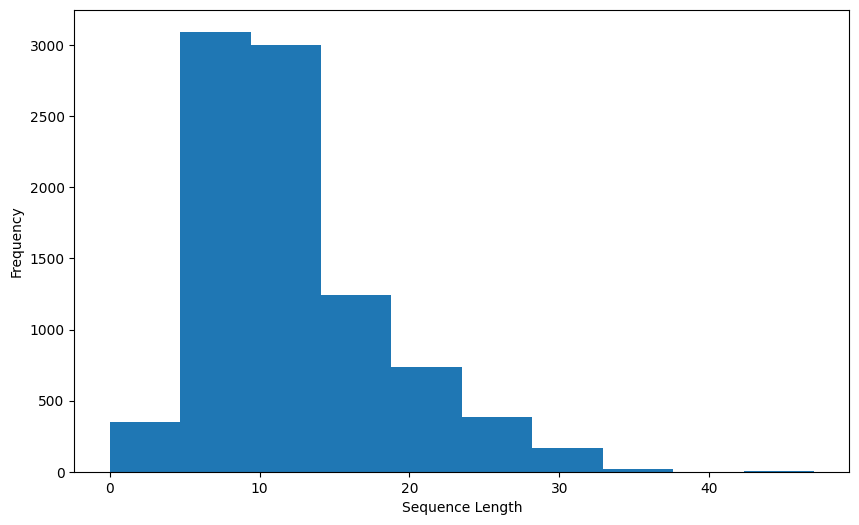

In [8]:
#tokenizer (Sentence)

tokenizer = Tokenizer()

tokenizer.fit_on_texts(df['Sentence'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['Sentence'])

sequence_length = [len(seq) for seq in sequences]

plt.figure(figsize=(10, 6))
plt.hist(sequence_length)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [9]:
#split data (Padded)
padded = pad_sequences(sequences, maxlen=40)

#Train Val Test -> 80 10 10
X_train, X_temp, y_train, y_temp = train_test_split(padded, df['Sentiment'], test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
#model definition

model = Sequential([ 
    Embedding(input_dim=len(word_index)+1, output_dim=512),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax'),
])

In [11]:
#compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
#fit model
early_stopping = EarlyStopping(monitor="val_loss", patience=3)

history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val), callbacks=early_stopping)

Epoch 1/20
57/57 [==============================] - 4s 57ms/step - loss: 1.0851 - accuracy: 0.4049 - val_loss: 1.0354 - val_accuracy: 0.4967
Epoch 2/20
57/57 [==============================] - 3s 57ms/step - loss: 0.8325 - accuracy: 0.6503 - val_loss: 0.7471 - val_accuracy: 0.6344
Epoch 3/20
57/57 [==============================] - 3s 56ms/step - loss: 0.5520 - accuracy: 0.7986 - val_loss: 0.5156 - val_accuracy: 0.8311
Epoch 4/20
57/57 [==============================] - 3s 54ms/step - loss: 0.2748 - accuracy: 0.9040 - val_loss: 0.4002 - val_accuracy: 0.8467
Epoch 5/20
57/57 [==============================] - 3s 55ms/step - loss: 0.1806 - accuracy: 0.9289 - val_loss: 0.4179 - val_accuracy: 0.8600
Epoch 6/20
57/57 [==============================] - 3s 54ms/step - loss: 0.1598 - accuracy: 0.9321 - val_loss: 0.3574 - val_accuracy: 0.8622
Epoch 7/20
57/57 [==============================] - 3s 55ms/step - loss: 0.1356 - accuracy: 0.9390 - val_loss: 0.3711 - val_accuracy: 0.8789
Epoch 8/20
57

Dipakai Early Stopping untuk mengecek apakah model mengalamai overfit artinya model yang dipakai
terlalu mengikuti training data sehingga bila diberi data baru tidak bisa mengklasifikasi data tersebut

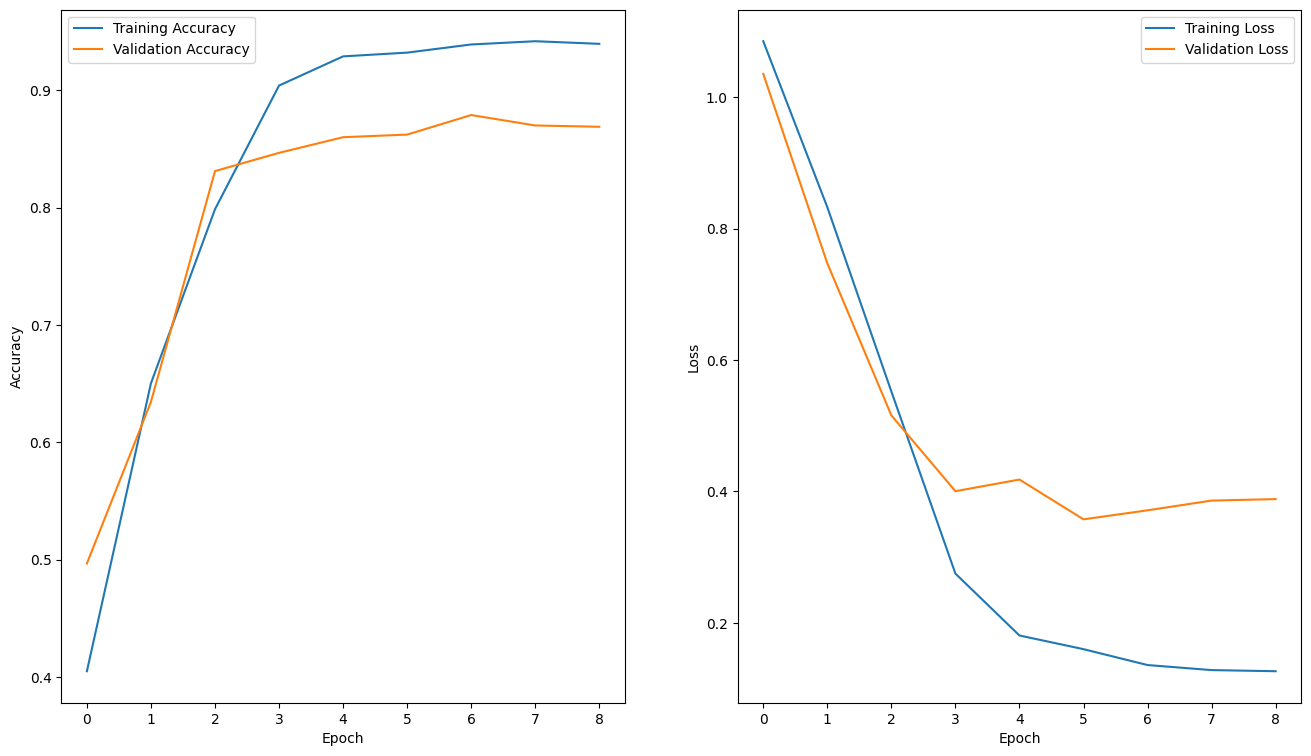

In [13]:
#plotting
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
#evaluate loss, accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(loss)
print(accuracy)

29/29 [==============================] - 0s 3ms/step - loss: 0.4281 - accuracy: 0.8656
0.42805710434913635
0.8655555844306946


In [15]:
#testing sirrrr
model.predict(X_test)

29/29 [==============================] - 0s 4ms/step


array([[9.9247921e-01, 7.5187096e-03, 2.0919708e-06],
       [9.9620432e-01, 3.7952655e-03, 4.2179320e-07],
       [9.8698145e-01, 1.2934260e-02, 8.4215615e-05],
       ...,
       [5.8630583e-05, 1.1423179e-03, 9.9879909e-01],
       [2.6232821e-01, 7.2400796e-01, 1.3663815e-02],
       [8.1950268e-03, 9.9173498e-01, 6.9971182e-05]], dtype=float32)